# Practical 2a - Audio Recognition with Convolutional Neural Networks (Part 1)

We are familiar with using Convolutional Neural Networks for image recognition. But did you know that Convolutional Neural Networks can also be used for non-image data, so long as you are able to devise a way to convert the data as an image.

For example, audio data can be visualized as a spectral view. But it can be converted into a smaller image using the Mel-Frequency Cepstral Coefficients (MFCC). This is exactly what we will be doing in this practical.

Before we start, ensure that you have the following dependencies set up.

```
!pip install numpy==1.19.3
!pip install pandas==1.2.0
!pip install opencv-python==4.5.1.48

!pip install scipy==1.6.0
!pip install matplotlib==3.3.3
!pip install seaborn==0.11.1
!pip install scikit-learn==0.24.0
!pip install librosa==0.8.0
```


## Section 1 - Preprocessing Our Audio Files

For this practical we will be using the Google's Voice Command dataset. The dataset can be downloaded from one of the following links:
   https://storage.cloud.google.com/download.tensorflow.org/data/speech_commands_v0.01.tar.gz (1.5GB)
   https://storage.cloud.google.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz (2.4GB)

The dataset used in this practical is obtained from the v0.01 link.


In [ ]:
# !pip install numpy==1.19.3
# !pip install pandas==1.2.0
!pip install opencv-python==4.5.1.48

!pip install scipy==1.6.0
!pip install matplotlib==3.3.3
!pip install seaborn==0.11.1
!pip install scikit-learn==0.24.0
!pip install librosa==0.8.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 MB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user


Download file from share directory of Google drive

In [1]:
!pip install gdown

In [2]:
import gdown
url=f"https://drive.google.com/uc?id=1Ev9kjlt1azdO-DDTsGR-v3lmUgKXYeLK"

output = 'speech_commands.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Ev9kjlt1azdO-DDTsGR-v3lmUgKXYeLK
To: /content/speech_commands.zip
100%|██████████| 222M/222M [00:05<00:00, 42.0MB/s]


'speech_commands.zip'

In [3]:
!unzip speech_commands.zip

Streaming output truncated to the last 5000 lines.
  inflating: speech_commands/on/0132a06d_nohash_1.wav  
  inflating: speech_commands/on/0132a06d_nohash_2.wav  
  inflating: speech_commands/on/0132a06d_nohash_3.wav  
  inflating: speech_commands/on/0132a06d_nohash_4.wav  
  inflating: speech_commands/on/0135f3f2_nohash_0.wav  
  inflating: speech_commands/on/0137b3f4_nohash_0.wav  
  inflating: speech_commands/on/0137b3f4_nohash_1.wav  
  inflating: speech_commands/on/0137b3f4_nohash_2.wav  
  inflating: speech_commands/on/0137b3f4_nohash_3.wav  
  inflating: speech_commands/on/0137b3f4_nohash_4.wav  
  inflating: speech_commands/on/016e2c6d_nohash_0.wav  
  inflating: speech_commands/on/019fa366_nohash_0.wav  
  inflating: speech_commands/on/01b4757a_nohash_0.wav  
  inflating: speech_commands/on/01bb6a2a_nohash_0.wav  
  inflating: speech_commands/on/01bb6a2a_nohash_1.wav  
  inflating: speech_commands/on/01bb6a2a_nohash_2.wav  
  inflating: speech_commands/on/01bb6a2a_nohash_3.wav

In [4]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from matplotlib import cm
import librosa
import os
from sklearn.model_selection import train_test_split



In [5]:
from google.colab import drive
drive.mount('/content/drive')
user_folder = '/content/drive/My Drive/Data/ITI108/D2'

Mounted at /content/drive


In [6]:
!ls /content/drive/My\ Drive/Data/ITI108/D2

speech_commands      x_mfcc1.npy  x_spec1.npy  y1.npy
speech_commands.zip  x_mfcc.npy   x_spec.npy   y.npy


### Define Useful Functions

Run the following cell to define all functions necessary for our processing to work.

Take a look at the convert_mfcc and convert_spec functions to see how we call the various functions in the librosa library to read the audio signal from the file and then convert the signal into the features.

In [10]:
# Each of our sample (22khz) lasts exactly 1 seconds with 22050 samples.
#
mfcc_hop_length = 512
spec_hop_length = 64

mfcc_max_frames = int(22050 / mfcc_hop_length) + 1 # this is actually about 22050 / 512.
spec_max_frames = int(22050 / spec_hop_length)     # this is actually about 22050 / 512.

print (mfcc_max_frames)
print (spec_max_frames)

max_mfcc_features = 40
num_classes = 10
max_samples = 22050

# Define the folders that stores our audio.
#
user_folder =""
audio_folder = user_folder + 'speech_commands'
labels = ["yes", "no", "up", "down", "left", "right", "stop", "go", "on", "off"]


# Scale the values to be between
def scale(arr):
    #arr = arr - arr.mean()
    safe_max = np.abs(arr).max()
    if safe_max == 0:
        safe_max = 1
    arr = arr / safe_max
    return arr


# This method takes a 2D numpy array and converts it into
# a 3D array representing a grayscale image with the RGB
# components.
#
# Since it is grayscale, the R, G, B components will have the
# same value for the same pixel.
#
def broadcast_rgb(feat):
    new_feat = np.zeros((feat.shape[0], feat.shape[1], 3))
    feat = feat.reshape((feat.shape[0], feat.shape[1], 1))

    # broadcast the single gray component into the R,G,B components
    new_feat[:, :, :] = feat[:, :, 0:1]
    return new_feat



# Load a file and convert its audio signal into a series of MFCC
# This will return a 2D numpy array.
#
def convert_mfcc(file_name):
    signal, sample_rate = librosa.load(file_name)
    signal = librosa.util.normalize(signal)
    signal, index = librosa.effects.trim(signal, top_db=60)

    feature = (librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=max_mfcc_features).T)
    # print(feature.shape)
    feature = cv2.resize(feature, (40, 40), interpolation = cv2.INTER_CUBIC)

    feature = scale(feature)
    return feature


# Load a file and convert its audio signal into a spectrogram
# This will return a 2D numpy array.
#
def convert_spectral(file_name):
    signal, sample_rate = librosa.load(file_name)
    signal = librosa.util.normalize(signal)
    signal, index = librosa.effects.trim(signal, top_db=60)

    feature = np.abs(librosa.stft(y=signal, hop_length=spec_hop_length, win_length=spec_hop_length*4, n_fft=spec_hop_length*4, center=False).T)

    feature = librosa.amplitude_to_db(feature)
    feature = cv2.resize(feature, (80, 80), interpolation = cv2.INTER_CUBIC)
    feature = scale(feature)

    return feature


audio_folder


44
344


'speech_commands'

Next, let's load some WAV files from our download folders and display the MFCC and spectral features.

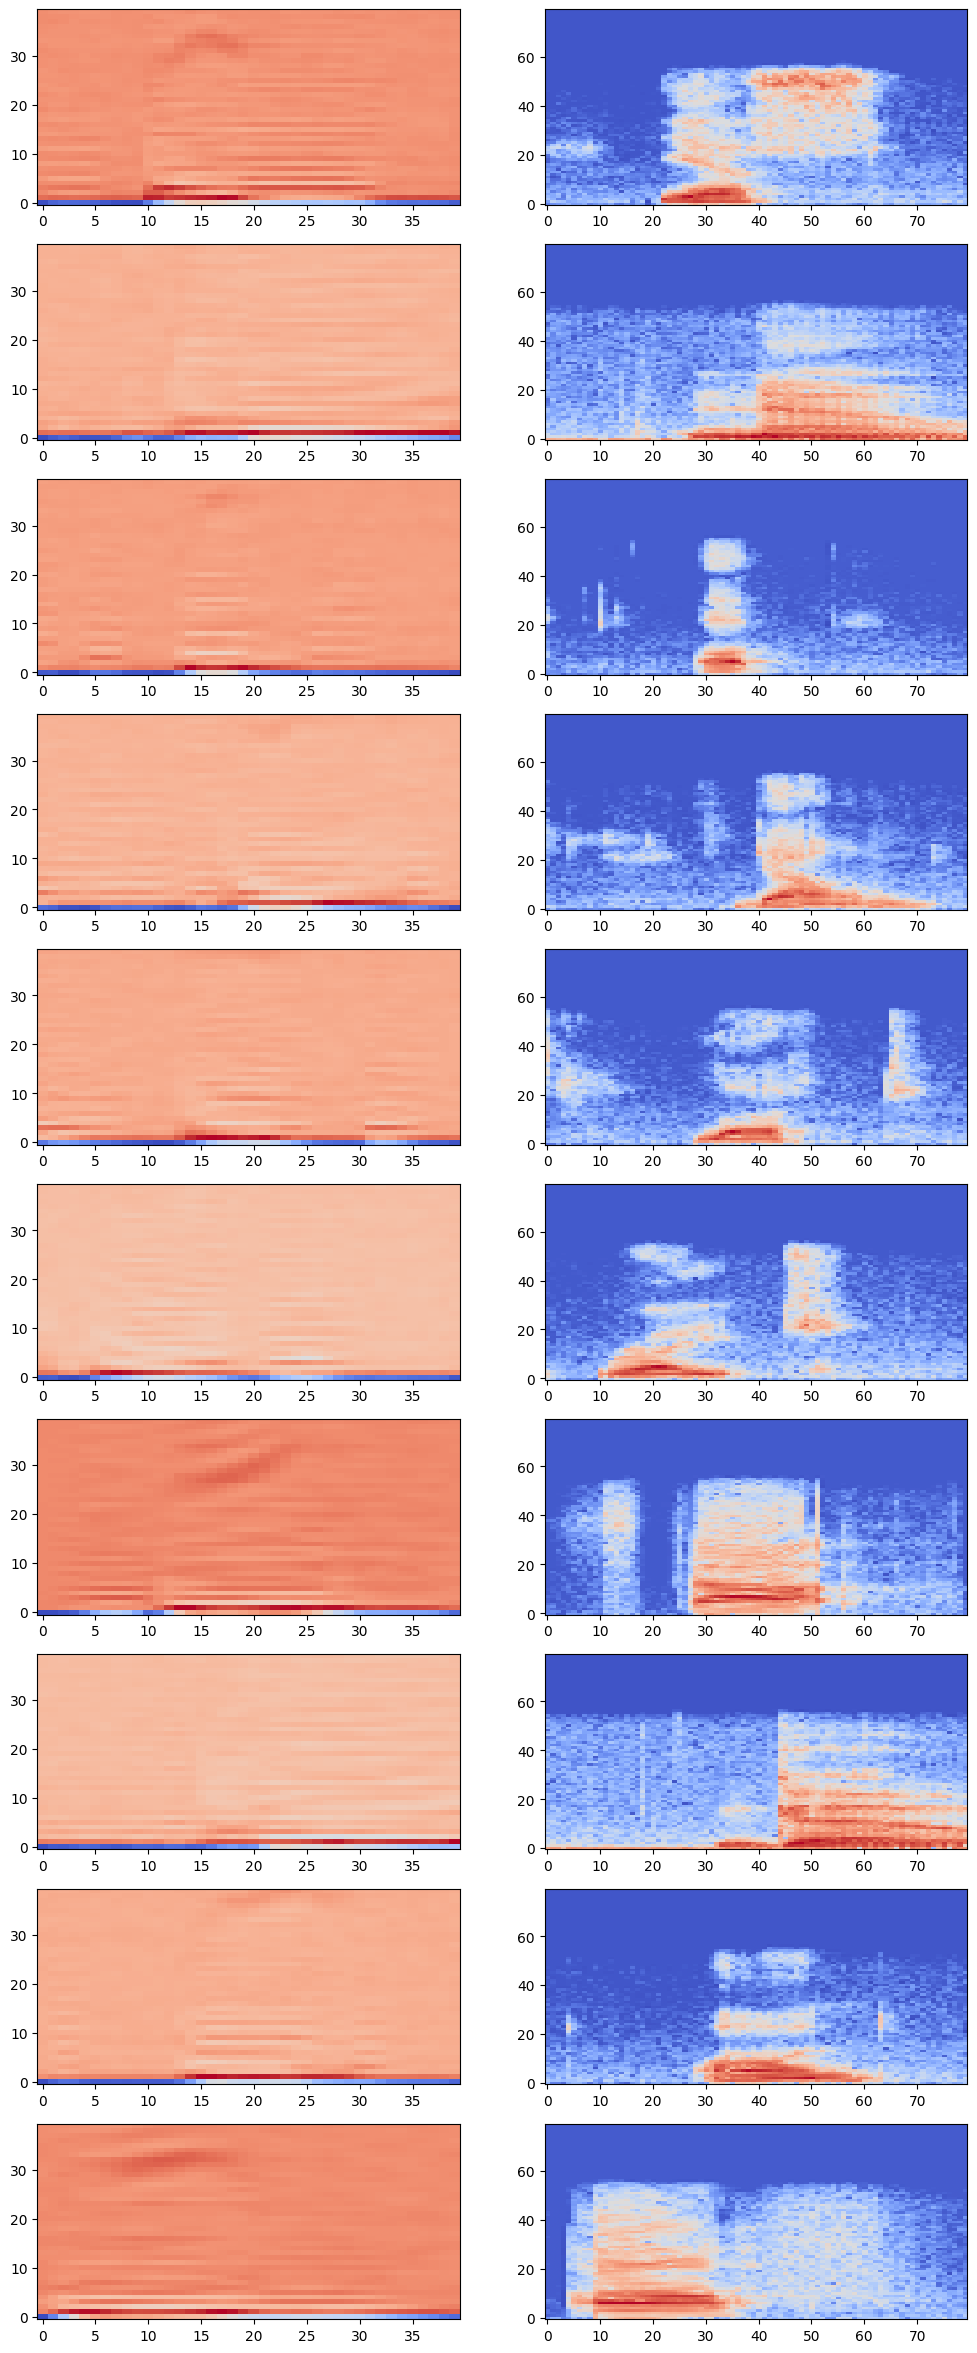

In [11]:
# This is just to test our convert_mfcc function. Once our audio is
# converted into their MFCC coefficients, plot it out as a 2D graph
# to see its form.
#

files = [
    "yes/0a7c2a8d_nohash_0.wav",
    "no/0a9f9af7_nohash_0.wav",
    "up/0a7c2a8d_nohash_0.wav",
    "down/0a7c2a8d_nohash_0.wav",
    "left/0a7c2a8d_nohash_0.wav",
    "right/0a7c2a8d_nohash_0.wav",
    "stop/0ab3b47d_nohash_0.wav",
    "go/0a9f9af7_nohash_0.wav",
    "on/0a7c2a8d_nohash_0.wav",
    "off/0ab3b47d_nohash_0.wav",

    #"down/0f3f64d5_nohash_0.wav",
    #"down/0f3f64d5_nohash_1.wav",
    #"down/0f3f64d5_nohash_2.wav",
    #"left/0ff728b5_nohash_0.wav",
    #"left/0ff728b5_nohash_1.wav",
    #"left/0ff728b5_nohash_2.wav",
    #"left/0ff728b5_nohash_3.wav",
    ]
plt.figure(figsize=(12,len(files) * 3))

for i in range(0, len(files)):

    mfcc_feat = convert_mfcc(audio_folder + "/" + files[i])
    spectral_feat = convert_spectral(audio_folder + "/" + files[i])

    plt.subplot(len(files), 2, i*2 + 1)
    plt.imshow(mfcc_feat.T, cmap=cm.coolwarm, interpolation='nearest', origin='lower', aspect='auto')
    plt.subplot(len(files), 2, i*2 + 2)
    plt.imshow(spectral_feat.T, cmap=cm.coolwarm, interpolation='nearest', origin='lower', aspect='auto')
plt.show()



Then, let's load up all the audio files, convert them to MFCC and pack them into numpy arrays and save the arrays into a file.

Copy the following code into the #...# section below.

```
# TODO:
# Write a loop to run through all 10 command labels
#
#...#
for i in range(0, len(labels)):
    
    label = labels[i]
   
    print ("Label: " + labels[i])
    
    # TODO:
    # Write a loop to run through all files within
    # the folder for the specific command label
    #...#    
    for root, dirs, files in os.walk(audio_folder + "/" + label, topdown=False):
        
        for file in files:
        
            filepath = audio_folder + "/" + label + "/" + file
            if not ".wav" in filepath:
                continue
            
            # TODO:
            # Extract the MFCC Features and create the
            # the expected prediction (one-hot), Y
            #...#
            mfcc_feat = convert_mfcc(filepath)
            x_mfcc.append(mfcc_feat)
            spec_feat = convert_spectral(filepath)
            x_spec.append(spec_feat)

            y_hot = [0] * 10
            y_hot[i] = 1
            y.append(y_hot)
            
# TODO:
# Convert the data into numpy arrays.
x_mfcc = np.array(x_mfcc)
x_spec = np.array(x_spec)
y = np.array(y)

```

In [12]:
y = []
x_mfcc = []
x_spec = []

max_samples_per_class = 400
batch_size = 40

# Process our wave files into MFCC and spectral features.
#
print ("Processing...")



for i in range(0, len(labels)):

    label = labels[i]

    print ("Label: " + labels[i])

    # TODO:
    # Write a loop to run through all files within
    # the folder for the specific command label
    #...#
    for root, dirs, files in os.walk(audio_folder + "/" + label, topdown=False):

        for file in files:

            filepath = audio_folder + "/" + label + "/" + file
            if not ".wav" in filepath:
                continue

            # TODO:
            # Extract the MFCC Features and create the
            # the expected prediction (one-hot), Y
            #...#
            mfcc_feat = convert_mfcc(filepath)
            x_mfcc.append(mfcc_feat)
            spec_feat = convert_spectral(filepath)
            x_spec.append(spec_feat)

            y_hot = [0] * 10
            y_hot[i] = 1
            y.append(y_hot)

# TODO:
# Convert the data into numpy arrays.
x_mfcc = np.array(x_mfcc)
x_spec = np.array(x_spec)
y = np.array(y)



print ('Done.')


Processing...
Label: yes
Label: no
Label: up
Label: down
Label: left
Label: right
Label: stop
Label: go
Label: on
Label: off
Done.


### Save the data

Update the following cell below to save the x_mfcc, x_spec and y into separate .npy files.

Use the following code:

```
np.save(user_folder+"x_mfcc.npy", x_mfcc)
np.save(user_folder+"x_spec.npy", x_spec)
np.save(user_folder+"y.npy", y)
```

In [13]:
# TODO:
# Add codes below to save the x_mfcc, x_spec and y arrays into .npy files
#...#
np.save("x_mfcc1.npy", x_mfcc)
np.save("x_spec1.npy", x_spec)
np.save("y1.npy", y)
np.save(user_folder+"/x_mfcc1.npy", x_mfcc)
np.save(user_folder+"/x_spec1.npy", x_spec)
np.save(user_folder+"/y1.npy", y)

### Copy Files to Google Drive

Copy the three .npy files into your Google Drive's Data/D2 folder.

Then, proceed to upload Practical 02b to Colab and run the training there.

